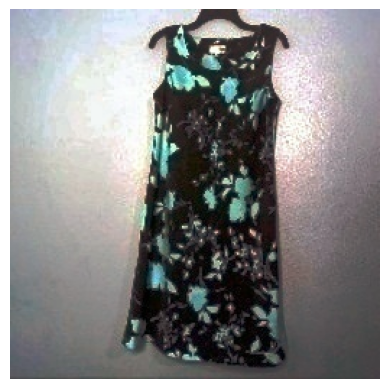

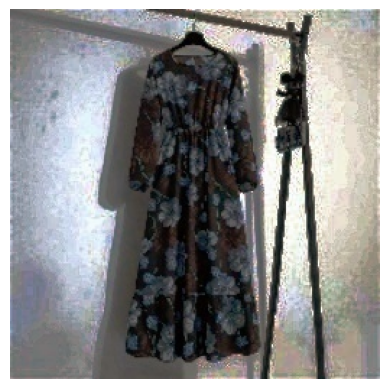

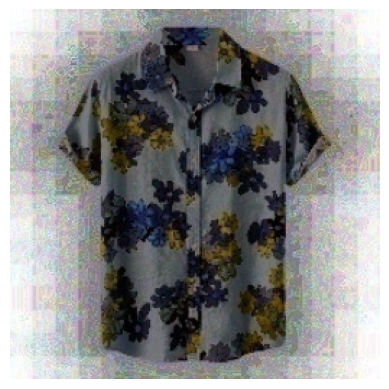

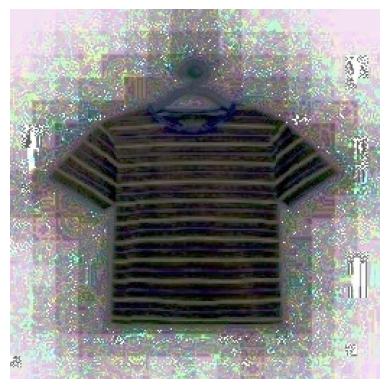

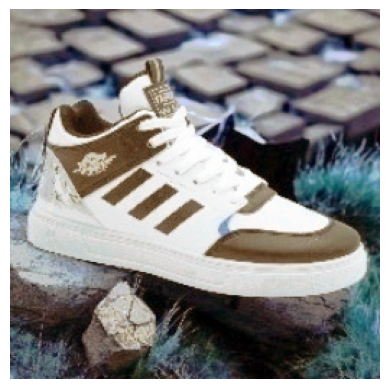

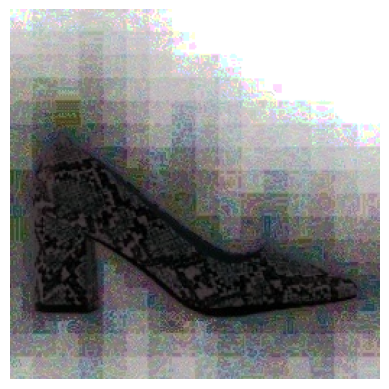

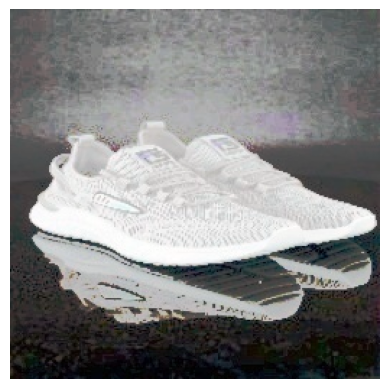

In [45]:
import cv2
import os
from skimage import exposure
import numpy as np # Import numpy for type conversion (converting floating-point pixel values back to the standard uint8 format for proper image representation.)
import matplotlib.pyplot as plt #for displaying images

# Set the folder path
folder_path = r'C:\University\7th Semester\SDP - I\FYP_code\fashion_dataset'

# Loop through each image in the folder
for image_file in os.listdir(folder_path):
    # Construct the full path to each image file
    image_path = os.path.join(folder_path, image_file)
    # Read the image from the specified path
    image = cv2.imread(image_path)

    # Check if the file is an image (some non-image files may be in the folder)
    if image is not None:

        # Resize the image to a standard size (256x256)
        resized_image = cv2.resize(image, (256, 256))

        # Convert the image from BGR (OpenCV format) to RGB (scikit-image format)
        rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

        # Split the image into its RGB components
        r, g, b = cv2.split(rgb_image)

        # Apply histogram equalization to each channel separately (enhance contrast)
        r_eq = exposure.equalize_hist(r)
        g_eq = exposure.equalize_hist(g)
        b_eq = exposure.equalize_hist(b)

        # Merge the equalized channels back into a single image
        enhanced_image = cv2.merge((r_eq, g_eq, b_eq))

        # Scale the enhanced image back to the [0, 255] range and convert to uint8
        enhanced_image_uint8 = (enhanced_image * 255).astype(np.uint8)

        # Convert the enhanced image back to BGR for saving
        enhanced_image_bgr = cv2.cvtColor(enhanced_image_uint8, cv2.COLOR_RGB2BGR)

        # Save the processed image (overwrite the original image)
        cv2.imwrite(image_path, enhanced_image_bgr)

        # Display the processed image using matplotlib (optional)
        plt.imshow(enhanced_image_bgr)  # Shows processed image in new window
        plt.axis('off')  # Hide axes (xy labels) around the image for a cleaner look
        plt.show()  # Render the image on the screen  

    else:
        print(f"'{image_file}' is not a valid image file and will be skipped.")


In [5]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

folder_path = r'C:\University\7th Semester\SDP - I\FYP_code\fashion_dataset'

# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

features_list = []  # List to store feature vectors

# Loop through each image in the folder
for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)

    if image is not None:
        # Resize and preprocess the image
        resized_image = cv2.resize(image, (256, 256))
        image_array = np.expand_dims(resized_image, axis=0)
        preprocessed_image = preprocess_input(image_array)

        # Extract features
        features = feature_extractor.predict(preprocessed_image)
        features_list.append(features.flatten())  # Flatten the feature map

# Convert features list to NumPy array for further processing
features_array = np.array(features_list)

# Saving features to a NumPy file for later use
np.save('features.npy', features_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [7]:
print(features_array.shape)  # shows the number of images and the feature vector size.


(7, 32768)


In [9]:
print("Summary of feature vectors:\n", features_array)


Summary of feature vectors:
 [[0.        0.        0.        ... 0.        7.3641925 0.       ]
 [2.9952955 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        1.521399  ... 0.        8.651592  0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [25]:
print("Shape of the first feature vector:", features_array[0].shape) #Prints the shape of the first feature vector, showing its dimensions 


Shape of the first feature vector: (32768,)


In [6]:
!pip install faiss-cpu


import numpy as np
import faiss  

# Load features from the .npy file
features_array = np.load('features.npy')

#  Create a FAISS index
index = faiss.IndexFlatL2(features_array.shape[1])  # L2 distance index (straight-line)

# Add the feature vectors to the index
index.add(features_array) 

# Print no. of vectors in the index
print("Number of vectors in the index:", index.ntotal)


Number of vectors in the index: 7


In [28]:
# Performing a test search with the first feature vector
D, I = index.search(features_array[0:1], k=5)  # Find the 5 nearest neighbors
print("Distances of nearest neighbors:", D)
print("Indices of nearest neighbors:", I)


Distances of nearest neighbors: [[      0.  2315968.  2385614.5 2394611.8 2874583.5]]
Indices of nearest neighbors: [[0 1 6 2 5]]


In [ ]:
pip install pymongo


In [4]:
from pymongo import MongoClient
import numpy as np

# Load the features array
features_array = np.load('features.npy')
print("Feature vectors loaded successfully!")
print(f"Array dimensions: {features_array.shape}")


Feature vectors loaded successfully!
Array dimensions: (7, 32768)


In [8]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['Fashion_Visual_db']  
collection = db['Feature_Vectors']  

# Store feature vectors in MongoDB
for i, vector in enumerate(features_array):
    # Check if the item_id already exists in the collection
    if collection.find_one({"item_id": i}) is None:
        document = {
            "item_id": i,  # Unique identifier for each vector
            "feature_vector": vector.tolist()  # Convert array to list for storage
        }
        collection.insert_one(document)

print("Feature vectors have been added without duplicates.")


Feature vectors have been added without duplicates.


In [7]:

# Fetch a specific document by item_id
query_result = collection.find_one({"item_id": 0})  
print("Fetched document:", query_result)


Fetched document: {'_id': ObjectId('673b73e1478259a99e526395'), 'item_id': 0, 'feature_vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.13829231262207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.482068061828613, 0.0, 10.75152587890625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.6934494972229, 0.0, 0.0, 0.0, 7.9460673332214355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.472054958343506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.022351264953613, 0.0, 0.0, 0.0, 36.14139938354492, 0.0, 0.0, 0.0, 0.0, 0.0, 6.212221145629883, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.178394317626953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [10]:
inserted_count = collection.count_documents({})
print(f"Total documents in collection: {inserted_count}")


Total documents in collection: 7


In [14]:
for i, vector in enumerate(features_array):
    print(f"Item {i}: Feature vector length is {len(vector)}")  #the no. of elements in it

Item 0: Feature vector length is 32768
Item 1: Feature vector length is 32768
Item 2: Feature vector length is 32768
Item 3: Feature vector length is 32768
Item 4: Feature vector length is 32768
Item 5: Feature vector length is 32768
Item 6: Feature vector length is 32768


In [26]:
print(f"First feature vector: {features_array[0][:50]}...")  # Print first 50 values


First feature vector: [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         5.3441844
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  8.5282755  0.        10.667789   0.         0.         0.
  0.         0.       ]...


In [32]:
#helps determine the sparsity of the feature vector
non_zero_count = np.count_nonzero(features_array[0])
print(f"Number of non-zero values: {non_zero_count}") 


Number of non-zero values: 3844


In [40]:
#performed this to ensure we're going right (analyze sparsity)
non_zero_indices = np.nonzero(features_array[0])[0]  # Get indices of non-zero elements
non_zero_values = features_array[0][non_zero_indices]  # Get values at those indices
print(f"Non-zero indices: {non_zero_indices[:10]}...")  # Print the first 10 indices
print(f"Non-zero values: {non_zero_values[:10]}...")  # Print the first 10 non-zero values


Non-zero indices: [ 17  42  44  55  59  99 103 113 117 123]...
Non-zero values: [5.3441844e+00 8.5282755e+00 1.0667789e+01 5.0275030e+00 8.8522997e+00
 3.4568560e+00 1.5101567e-02 9.2855244e+00 3.5738770e+01 5.9863176e+00]...
